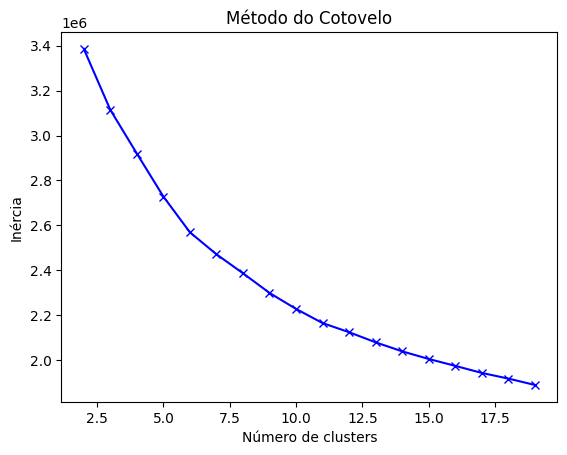

In [2]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


# músicas
df_main = pd.read_csv('data/data.csv')
# gêneros por artista
df_genres = pd.read_csv('data/data_w_genres.csv')
# médias por artista
df_artist = pd.read_csv('data/data_by_artist.csv')
# médias por ano
df_year = pd.read_csv('data/data_by_year.csv')
# médias por gênero
df_genre_avg = pd.read_csv('data/data_by_genres.csv')

# Corrige o nome da coluna de gêneros para remover espaços extras
colunas_corrigidas = [col.strip() for col in df_genre_avg.columns]
df_genre_avg.columns = colunas_corrigidas

# Normaliza 'artists' para facilitar merges
df_main['artists'] = df_main['artists'].apply(lambda x: x.strip("[]").replace("'", "").replace('"', '').strip())
df_genres['artists'] = df_genres['artists'].apply(lambda x: x.strip("[]").replace('"', '').strip())
df_artist['artists'] = df_artist['artists'].apply(lambda x: x.strip("[]").replace('"', '').strip())

# Merge com gêneros (adiciona coluna 'genres' ao dataset principal)
df_enriched = df_main.merge(df_genres[['artists', 'genres']], on='artists', how='left')

# Merge com médias por artista (adiciona colunas *_artist_avg)
df_enriched = df_enriched.merge(df_artist, on='artists', suffixes=('', '_artist_avg'), how='left')

# Merge com médias por ano (adiciona colunas *_year_avg)
if 'year' in df_enriched.columns:
    df_enriched = df_enriched.merge(df_year, on='year', suffixes=('', '_year_avg'), how='left')

# Merge com médias por gênero (adiciona colunas *_genre_avg usando o primeiro gênero)
def get_first_genre(genres):
    if isinstance(genres, str) and genres.strip():
        return genres.split(',')[0].replace('[','').replace(']','').replace("'",'').replace('"','').strip()
    return ''
df_enriched['main_genre'] = df_enriched['genres'].apply(get_first_genre)
df_genre_avg['genres'] = df_genre_avg['genres'].str.strip()
df_enriched = df_enriched.merge(df_genre_avg, left_on='main_genre', right_on='genres', suffixes=('', '_genre_avg'), how='left')


# Seleção e normalização das features enriquecidas para recomendação
feature_cols = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'popularity',
    # médias por artista
    'danceability_artist_avg', 'energy_artist_avg', 'loudness_artist_avg', 'speechiness_artist_avg',
    'acousticness_artist_avg', 'instrumentalness_artist_avg', 'liveness_artist_avg', 'valence_artist_avg', 'tempo_artist_avg',
    # médias por ano
    'acousticness_year_avg', 'danceability_year_avg', 'energy_year_avg', 'instrumentalness_year_avg',
    'liveness_year_avg', 'loudness_year_avg', 'speechiness_year_avg', 'tempo_year_avg', 'valence_year_avg',
    # médias por gênero
    'acousticness_genre_avg', 'danceability_genre_avg', 'energy_genre_avg', 'instrumentalness_genre_avg',
    'liveness_genre_avg', 'loudness_genre_avg', 'speechiness_genre_avg', 'tempo_genre_avg', 'valence_genre_avg'
]

feature_cols = [col for col in feature_cols if col in df_enriched.columns]
df_enriched_clean = df_enriched.dropna(subset=feature_cols)  # remove linhas com valores ausentes

# Normaliza as features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_enriched_clean[feature_cols])

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K = range(2, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()
